# EEG Analysis Pipeline for Grasp and Lift Hand Movements Prediction

This notebook is designed for processing EEG data from the Kaggle Challenge: Grasp-and-Lift EEG Detection, available at the following [link](https://www.kaggle.com/competitions/grasp-and-lift-eeg-detection/overview).

In [1]:
# Import all the packages
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


## Merge all databases in a general one for data processing

The `df_unifier` function processes EEG data from CSV files located in the specified directory (`first_dir`). It unifies the data and events files, creating a combined DataFrame. The function also allows limiting the number of files to process through the `file_limit` parameter.

### Parameters:
- `first_dir`: The directory path containing the EEG data CSV files.
- `file_limit` (optional): Limits the number of files to process. If not specified (or set to `None`), all files in the directory will be processed.

### Steps:
1. **Initialization:**
   - Initializes an empty list `all_dataframes` to store DataFrames.
   - Lists all CSV files in the specified directory.

2. **Processing CSV Files:**
   - Iterates through the CSV files in the directory.
   - Reads events CSV files and drops rows with NaN values.
   - Reads data CSV files with specific data types and decimal separator, dropping rows with NaN values.

3. **Merging DataFrames:**
   - Merges the events DataFrame with the data DataFrame using the 'id' column as the key.

4. **Data Transformation:**
   - Splits the values in the first column of the combined DataFrame by underscores.
   - Creates separate columns for subject, series, and sample by extracting numerical values from the split values.
   - Removes the original 'id' column.

5. **Return Value:**
   - Returns the processed and combined DataFrame.


In [2]:
# Set the directory path where your CSV files are located
train_path = '/content/drive/MyDrive/Colab Notebooks/Project_NEURO/train/'

test_path = ''


def df_unifier(first_dir, file_limit=None):
    # Initialize an empty list to store DataFrames
    all_dataframes = []

    # List the CSV files in the directory
    csv_files = [filename for filename in os.listdir(first_dir) if filename.endswith(".csv")]

    # If file_limit is None, set it to the total number of files
    if file_limit is None:
        file_limit = len(csv_files)

    # Create a tqdm progress bar
    with tqdm(total=min(len(csv_files), file_limit), desc="Processing CSV files") as pbar:
        # Initialize a counter for processed files
        file_count = 0
        # Loop through files in the 1st directory
        for filename in csv_files:
            if file_count >= file_limit:
                break  # Exit the loop if the file limit is reached

            file_path = os.path.join(first_dir, filename)

            # Check if the file is an events file or a data file
            if "events" in filename:
                # Read events CSV file and drop rows with NaN values
                events_df = pd.read_csv(file_path).dropna()
            else:
                # Read data CSV file with a specific dtype and decimal separator
                dtype = {'Fp1': float, 'Fp2': float, 'F7': float, 'F3': float, 'Fz': float, 'F4': float, 'F8': float,
                         'FC5': float, 'FC1': float, 'FC2': float, 'FC6': float, 'T7': float, 'C3': float, 'Cz': float,
                         'C4': float, 'T8': float, 'TP9': float, 'CP5': float, 'CP1': float, 'CP2': float, 'CP6': float,
                         'TP10': float, 'P7': float, 'P3': float, 'Pz': float, 'P4': float, 'P8': float, 'PO9': float,
                         'O1': float, 'Oz': float, 'O2': float, 'PO10': float}
                data_df = pd.read_csv(file_path, dtype=dtype, decimal='.', na_values=[''], keep_default_na=False).dropna()

            pbar.update(1)  # Update the progress bar
            file_count += 1

    # Merge the events DataFrame with the data DataFrame using the 'id' column
    combined_df = pd.merge(data_df, events_df, on='id')

    # Split the values in the first column by underscores
    split_values = combined_df.iloc[:, 0].str.split('_')

    # Create separate columns for subject, series, and sample
    combined_df['Subject'] = split_values.str[0].str.extract(r'(\d+)').astype(int)
    combined_df['Series'] = split_values.str[1].str.extract(r'(\d+)').astype(int)
    combined_df['Sample'] = split_values.str[2].str.extract(r'(\d+)').astype(int)

    # Remove the first column ('id')
    combined_df = combined_df.iloc[:, 1:]

    return combined_df
# Limit the number of CSV files to read (e.g., 10)
file_limit = None
train_df = df_unifier(train_path, file_limit=file_limit)

Processing CSV files: 100%|██████████| 192/192 [02:41<00:00,  1.19it/s]


In [3]:
train_df.head(5)

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,PO10,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased,Subject,Series,Sample
0,-1327.0,-1243.0,-382.0,-6.0,-133.0,154.0,-2045.0,434.0,1246.0,-116.0,...,-63.0,0,0,0,0,0,0,12,8,0
1,-1370.0,-1267.0,-222.0,43.0,-121.0,32.0,-2038.0,420.0,1244.0,-134.0,...,-79.0,0,0,0,0,0,0,12,8,1
2,-1351.0,-1299.0,-50.0,34.0,-99.0,285.0,-1895.0,452.0,1270.0,-95.0,...,-276.0,0,0,0,0,0,0,12,8,2
3,-1359.0,-1197.0,26.0,-24.0,-109.0,290.0,-1979.0,458.0,1266.0,-100.0,...,-282.0,0,0,0,0,0,0,12,8,3
4,-1466.0,-1040.0,28.0,-42.0,-119.0,252.0,-1982.0,454.0,1260.0,-125.0,...,77.0,0,0,0,0,0,0,12,8,4


## Plot all EEG channels indivually

The `plot_filtered_data` function is designed to visualize EEG data for specific channels, focusing on a particular condition, subject, and series. It filters the input DataFrame based on the provided condition, subject, and series values and plots the specified EEG channels.

### Parameters:
- `df`: The input DataFrame containing EEG data.
- `columns_to_plot`: A list of EEG channel names to be plotted.
- `condition_to_select`: The specific condition (e.g., 'HandStart') to filter the data for visualization.
- `subject_value`: The subject ID for data filtering.
- `series_value`: The series ID for data filtering.
- `num_rows`: The number of rows to include in the visualization.

### Steps:
1. **Filtering Data:**
   - Filters the input DataFrame based on the provided subject and series values.
   - Sets all other condition columns to 0 except for the selected condition to focus visualization on a specific event.

2. **Further Filtering:**
   - Filters the DataFrame further to include only rows where the selected condition is 1.

3. **Plotting EEG Channels:**
   - Creates a subplot grid based on the number of EEG channels to be plotted.
   - Iterates through the specified EEG channels and plots them on separate subplots.
   - Each subplot represents a channel's values over the samples for the selected condition.
   - Sets titles, labels, and adjusts layout for each subplot.

4. **Display:**
   - Displays the plots to visualize EEG data for the selected channels and condition.

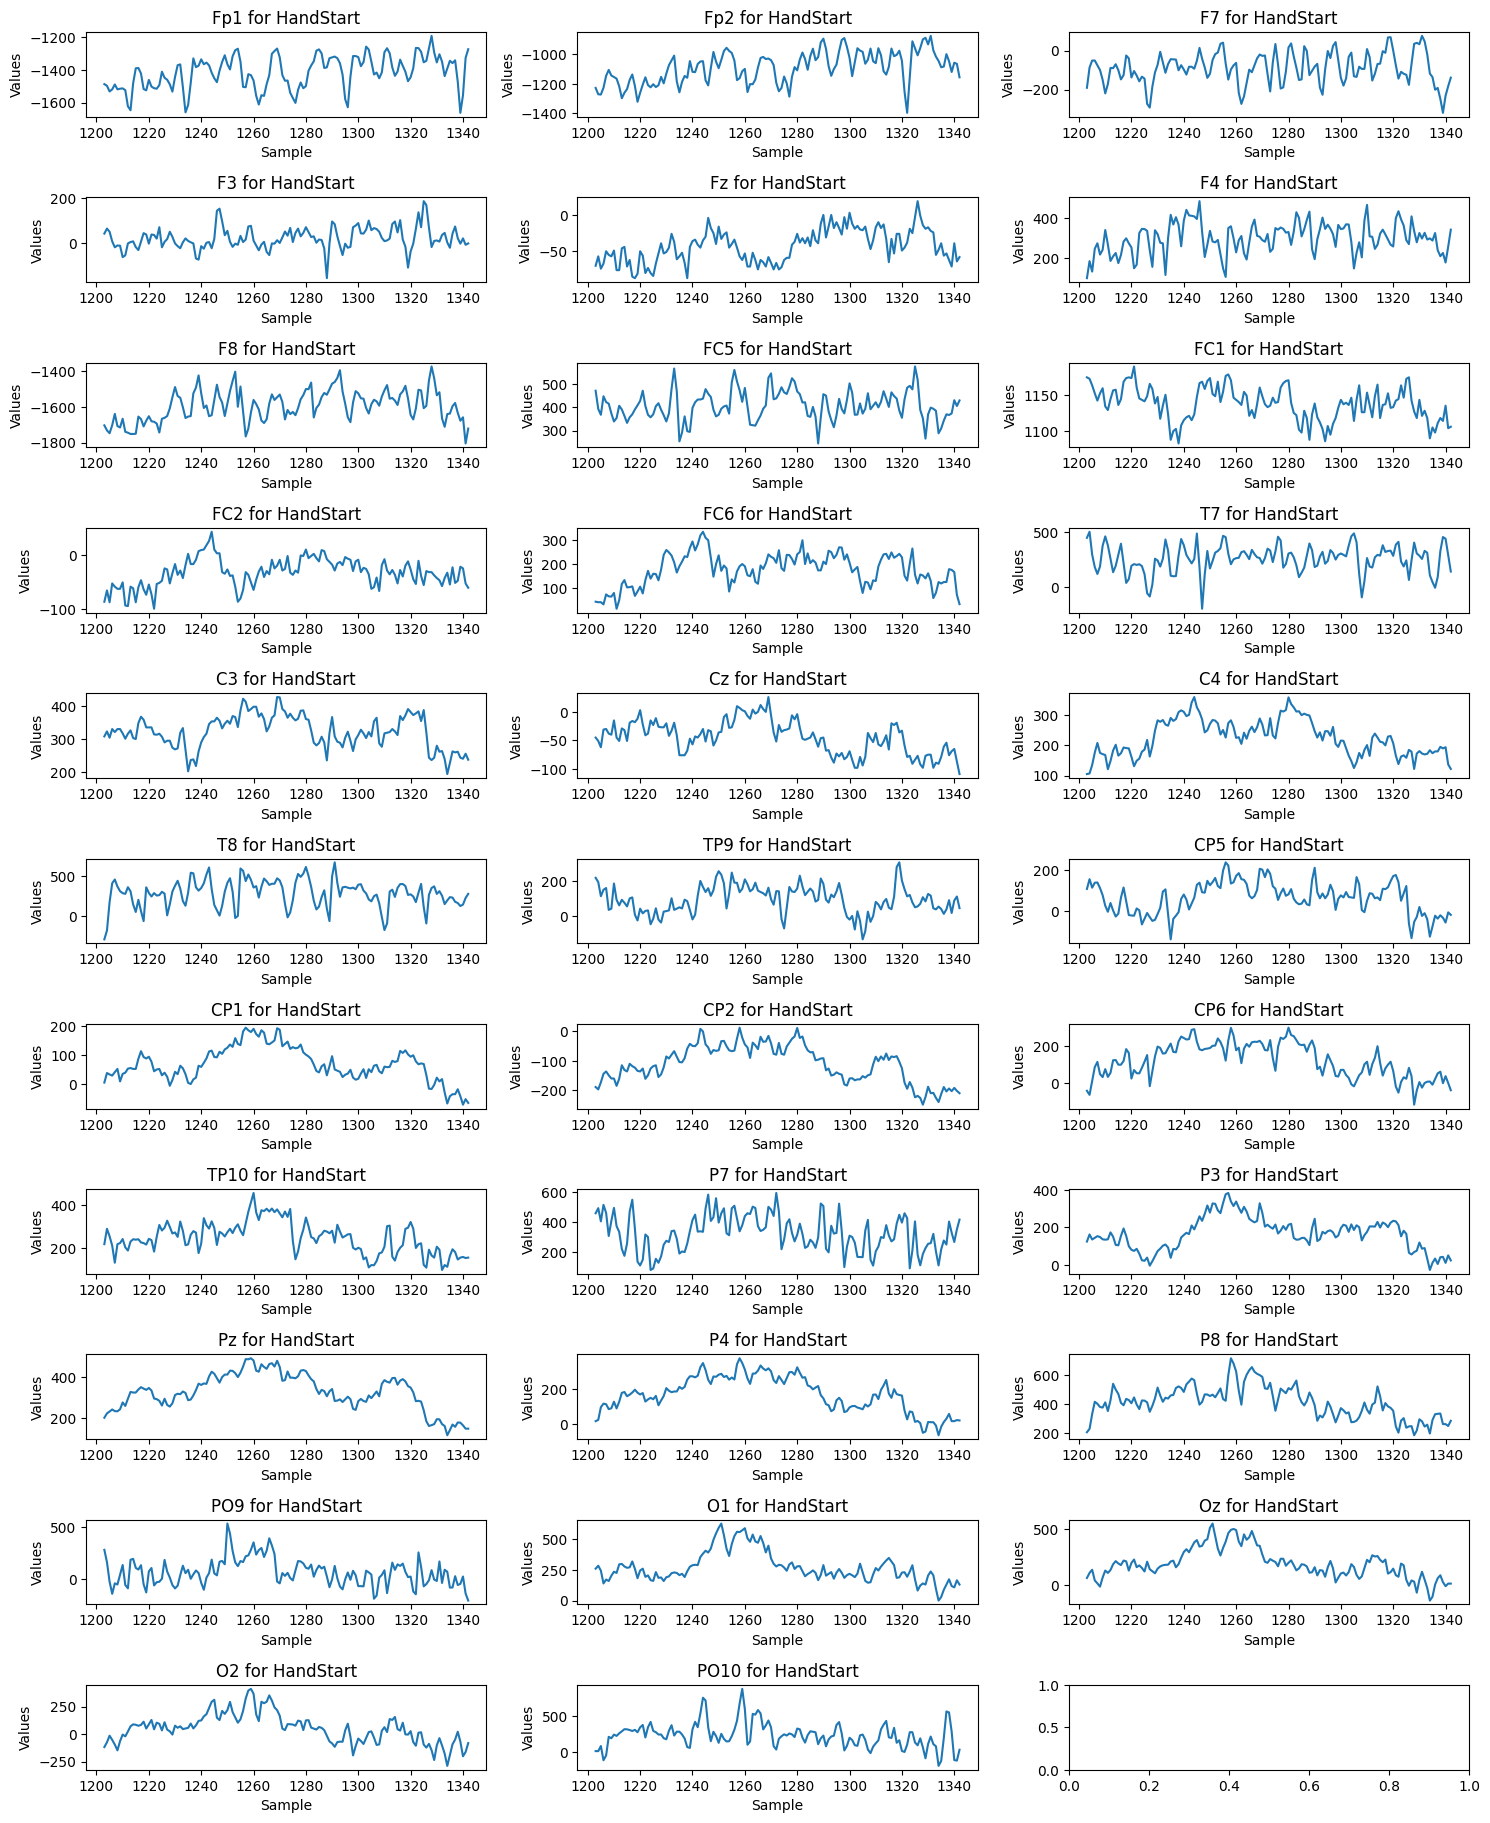

In [4]:
def plot_filtered_data(df, columns_to_plot, condition_to_select, subject_value, series_value, num_rows):
    # Filter the DataFrame based on Subject and Series values
    filtered_df = df[(df['Subject'] == subject_value) & (df['Series'] == series_value)]

    # Set all other condition columns to 0 except for the selected condition
    condition_columns = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']
    for col in condition_columns:
        if col == condition_to_select:
            continue
        filtered_df[col] = 0

    # Filter the DataFrame further to include only rows where the selected condition is 1
    filtered_df = filtered_df[filtered_df[condition_to_select] == 1]

    # Select the first 'num_rows' rows
    filtered_df = filtered_df.iloc[:num_rows]

    # Calculate the number of rows and columns for the subplot grid
    num_plots = len(columns_to_plot)
    num_columns = 3
    num_rows = math.ceil(num_plots / num_columns)

    # Create subplots with 3 columns and 1/3 of the height
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows/3))

    for i, column in enumerate(columns_to_plot):
        row_idx = i // num_columns
        col_idx = i % num_columns
        ax = axes[row_idx, col_idx]

        sns.lineplot(x='Sample', y=column, data=filtered_df, ax=ax)
        ax.set_title(f'{column} for {condition_to_select}')
        ax.set_xlabel('Sample')
        ax.set_ylabel('Values')

    # Adjust the layout
    plt.tight_layout()

    # Display the plots
    plt.show()


columns_to_plot = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
condition_to_select = 'HandStart'
subject_value = 12
series_value = 8
num_rows = 140

plot_filtered_data(train_df, columns_to_plot, condition_to_select, subject_value, series_value, num_rows)


## Visualizing all EEG channels together in a 3D surface plot

The `plot_filtered_data_3d_plotly` function visualizes EEG data using a 3D surface plot. It focuses on specific channels, subject, and series, displaying the relationship between samples, channels, and their corresponding values in a 3D space.

### Parameters:
- `df`: The input DataFrame containing EEG data.
- `channels`: A list of EEG channel names to be plotted in the 3D surface plot.
- `subject_value`: The subject ID for data filtering.
- `series_value`: The series ID for data filtering.
- `num_rows`: The number of rows to include in the visualization.

### Steps:
1. **Filtering Data:**
   - Filters the input DataFrame based on the provided subject and series values.
   - Selects the first 'num_rows' rows for visualization.

2. **Creating 3D Surface Plot:**
   - Creates a mesh grid (`X`, `Y`) representing samples and channel names.
   - Extracts values from the filtered DataFrame for the specified channels (`Z`).
   - Determines the channel spacing for better visualization.
   - Calculates tick values for the y-axis (channel names) based on channel spacing.
   - Creates a 3D surface plot using the Plotly library, representing samples, channels, and values in a 3D space.
   - Configures the layout with appropriate titles and axis labels.

3. **Display:**
   - Displays the interactive 3D surface plot using the Plotly library.

In [5]:
def plot_filtered_data_3d_plotly(df, channels, subject_value, series_value, num_rows):
    # Filter the DataFrame based on Subject and Series values
    filtered_df = df[(df['Subject'] == subject_value) & (df['Series'] == series_value)]

    # Select the first 'num_rows' rows
    filtered_df = filtered_df.iloc[:num_rows]

    # Create a mesh grid for the channels and values
    X, Y = pd.np.meshgrid(filtered_df['Sample'], channels)
    Z = filtered_df[channels].values.T

    # Determine the channel spacing
    channel_spacing = 10  # Increase this value for more spacing

    # Calculate the tickvals for the y-axis (channel)
    tickvals = [channel for channel in channels for _ in range(channel_spacing)]

    # Create a 3D surface plot
    trace = go.Surface(x=X, y=Y, z=Z, colorscale='Bluered')

    layout = go.Layout(
        title=f'3D Surface Plot for Channels with Subject {subject_value} and Series {series_value}',
        scene=dict(
            xaxis=dict(title='Sample'),
            yaxis=dict(
                title='Channel',
                tickvals=tickvals,  # Use the calculated tickvals
                ticktext=channels,  # Use the original channel names
                tickmode='array',  # Use an array of tickvals and ticktext
                showticklabels=True,  # Show tick labels
                tickangle=90,  # Rotate tick labels for better readability
            ),
            zaxis=dict(title='Values'),
        )
    )

    fig = go.Figure(data=[trace], layout=layout)
    fig.show()


channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
subject_value = 12
series_value = 8
num_rows = 140

plot_filtered_data_3d_plotly(train_df, channels, subject_value, series_value, num_rows)

<ipython-input-5-9c7733066e06>:9: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



## Random Forest classification on EEG data

The `random_forest` function performs a random forest classification on EEG data to predict specific event occurrences based on sensor readings. It uses the RandomForestClassifier from scikit-learn to train a model and evaluates its performance. The function also provides insights into feature importances to identify which sensors contribute most significantly to the predictions.

### Parameters:
- `df`: The input DataFrame containing EEG data.

### Steps:
1. **Data Preparation:**
   - Defines sensor columns (`sensor_columns`) representing EEG channels.
   - Defines target columns (`target_columns`) representing events to be predicted.

2. **Data Splitting:**
   - Splits the input data into training and testing sets (70% training, 30% testing) using the `train_test_split` function from scikit-learn.

3. **Random Forest Training:**
   - Initializes a RandomForestClassifier and trains it using the training data.
   - Makes predictions on the test set and calculates accuracy using `accuracy_score`.
   - Displays the accuracy score and the classification report, including precision, recall, and F1-score for each class.

4. **Feature Importance:**
   - Obtains feature importances from the trained random forest classifier.
   - Creates a DataFrame associating feature names (sensor columns) with their importances.
   - Sorts the DataFrame by importance in descending order.
   - Specifies the number of top features to display (e.g., top 10).
   - Displays the top N important features based on their importance scores.

In [ ]:
# Train a RF to classify movements based on sensor value

def random_forest(df):

  # Define the sensor columns
  sensor_columns = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']

  # Define the target columns
  target_columns = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']

  # Split the data into training and testing sets (70% training, 30% testing)
  X_train, X_test, y_train, y_test = train_test_split(df[sensor_columns], df[target_columns], test_size=0.3, random_state=42)

  # Initialize and train the Random Forest classifier
  clf = RandomForestClassifier(random_state=42)
  clf.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = clf.predict(X_test)

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')

  # Display classification report
  class_report = classification_report(y_test, y_pred, target_names=target_columns)
  print('Classification Report:\n', class_report)

  # Get feature importances
  feature_importances = clf.feature_importances_

  # Create a DataFrame to associate feature names with importances
  importance_df = pd.DataFrame({'Feature': sensor_columns, 'Importance': feature_importances})

  # Sort the DataFrame by importance in descending order
  importance_df = importance_df.sort_values(by='Importance', ascending=False)

  # Specify the number of top features you want to display (e.g., top 10)
  top_n = 10
  top_features = importance_df.head(top_n)

  # Display the top N important features
  print(f'Top {top_n} Important Features:')
  print(top_features)

random_forest(train_df)


Accuracy: 0.86
Classification Report:
                     precision    recall  f1-score   support

         HandStart       0.99      0.19      0.31      1547
   FirstDigitTouch       1.00      0.09      0.16      1521
BothStartLoadPhase       1.00      0.08      0.15      1541
           LiftOff       0.98      0.13      0.22      1451
           Replace       0.99      0.11      0.19      1520
      BothReleased       0.99      0.13      0.22      1562

         micro avg       0.99      0.12      0.21      9142
         macro avg       0.99      0.12      0.21      9142
      weighted avg       0.99      0.12      0.21      9142
       samples avg       0.02      0.02      0.02      9142

Top 10 Important Features:
   Feature  Importance
6       F8    0.049340
0      Fp1    0.044739
1      Fp2    0.042284
8      FC1    0.040208
21    TP10    0.039865
10     FC6    0.038916
2       F7    0.036478
13      Cz    0.035935
9      FC2    0.035217
18     CP1    0.034244


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.



## Key sensors per class (event type)

The `random_forest_features` function applies a random forest classifier separately to each target class (event type) in EEG data to identify the top features (sensors) contributing to the classification. It then associates these top features with their corresponding brain regions, providing insights into the most significant sensors for predicting specific events.

### Parameters:
- `df`: The input DataFrame containing EEG data.
- `features`: The number of top features (sensors) to display per class.

### Steps:
1. **Data Preparation:**
   - Defines sensor columns (`sensor_columns`) representing EEG channels.
   - Defines target columns (`target_columns`) representing events to be predicted.
   - Specifies the number of top features to display (`top_n_per_class`).

2. **Mapping Sensor Columns to Brain Regions:**
   - Creates a dictionary (`sensor_to_region`) mapping sensor columns to their corresponding brain regions.

3. **Random Forest and Feature Importance:**
   - Iterates over each target class and splits the data into training and testing sets (70% training, 30% testing).
   - Initializes and trains a RandomForestClassifier for each class.
   - Obtains feature importances and associates feature names with their importances using a DataFrame.
   - Sorts the DataFrame by importance in descending order and selects the top N features for the class.
   - Maps these top features to their corresponding brain regions using the `sensor_to_region` dictionary.

4. **Display:**
   - Displays the top N important features per class with associated brain regions.

In [ ]:
def random_forest_features(df, features):

  # Define the sensor columns
  sensor_columns = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']

  # Define the target columns
  target_columns = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff', 'Replace', 'BothReleased']

  # Specify the number of top features you want to display per class (e.g., top 5)
  top_n_per_class = features

  # Create a dictionary to map sensor columns to brain regions
  sensor_to_region = {
      'Fp1': 'Frontopolar region (Frontal, Left)',
      'Fp2': 'Frontopolar region (Frontal, Right)',
      'F7': 'Frontal region (Frontal, Left)',
      'F3': 'Frontal region (Frontal, Left)',
      'Fz': 'Frontal region (Frontal)',
      'F4': 'Frontal region (Frontal, Right)',
      'F8': 'Frontal region (Frontal, Right)',
      'FC5': 'Frontocentral region (Frontal-Central, Left)',
      'FC1': 'Frontocentral region (Frontal-Central, Left)',
      'FC2': 'Frontocentral region (Frontal-Central, Right)',
      'FC6': 'Frontocentral region (Frontal-Central, Right)',
      'T7': 'Temporal region (Temporal, Left)',
      'C3': 'Central region (Central, Left)',
      'Cz': 'Central region (Central)',
      'C4': 'Central region (Central, Right)',
      'T8': 'Temporal region (Temporal, Right)',
      'TP9': 'Temporal region (Temporal, Left)',
      'CP5': 'Centroparietal region (Central-Parietal, Left)',
      'CP1': 'Centroparietal region (Central-Parietal, Left)',
      'CP2': 'Centroparietal region (Central-Parietal, Right)',
      'CP6': 'Centroparietal region (Central-Parietal, Right)',
      'TP10': 'Temporal region (Temporal, Right)',
      'P7': 'Parietal region (Parietal, Left)',
      'P3': 'Parietal region (Parietal, Left)',
      'Pz': 'Parietal region (Parietal)',
      'P4': 'Parietal region (Parietal, Right)',
      'P8': 'Parietal region (Parietal, Right)',
      'PO9': 'Occipital region (Occipital, Left)',
      'O1': 'Occipital region (Occipital, Left)',
      'Oz': 'Occipital region (Occipital)',
      'O2': 'Occipital region (Occipital, Right)',
      'PO10': 'Occipital region (Occipital, Right)'
  }

  # Create an empty dictionary to store top features per class along with brain regions
  top_features_per_class = {}

  # Iterate over each target class
  for target_class in target_columns:
      # Split the data into training and testing sets (70% training, 30% testing)
      X_train, X_test, y_train, y_test = train_test_split(df[sensor_columns], df[target_class], test_size=0.3, random_state=42)

      # Initialize and train the Random Forest classifier
      clf = RandomForestClassifier(random_state=42)
      clf.fit(X_train, y_train)

      # Get feature importances
      feature_importances = clf.feature_importances_

      # Create a DataFrame to associate feature names with importances
      importance_df = pd.DataFrame({'Feature': sensor_columns, 'Importance': feature_importances})

      # Sort the DataFrame by importance in descending order
      importance_df = importance_df.sort_values(by='Importance', ascending=False)

      # Get the top N important features for this class
      top_n_features = importance_df.head(top_n_per_class)['Feature'].tolist()

      # Map sensor columns to brain regions for the top features
      top_features_with_regions = [f"{feature} - {sensor_to_region.get(feature, 'Unknown')}" for feature in top_n_features]

      # Store the top features for this class in the dictionary
      top_features_per_class[target_class] = top_features_with_regions

  # Display the top N important features per class with associated brain regions
  for target_class, top_features in top_features_per_class.items():
      print(f'Top {top_n_per_class} Features for Class "{target_class}":')
      for feature_with_region in top_features:
          print(feature_with_region)
      print()

random_forest_features(train_df, 10)

Top 10 Features for Class "HandStart":
F8 - Frontal region (Frontal, Right)
Cz - Central region (Central)
Fp2 - Frontopolar region (Frontal, Right)
Fp1 - Frontopolar region (Frontal, Left)
FC1 - Frontocentral region (Frontal-Central, Left)
CP2 - Centroparietal region (Central-Parietal, Right)
FC6 - Frontocentral region (Frontal-Central, Right)
P3 - Parietal region (Parietal, Left)
CP1 - Centroparietal region (Central-Parietal, Left)
CP5 - Centroparietal region (Central-Parietal, Left)

Top 10 Features for Class "FirstDigitTouch":
F8 - Frontal region (Frontal, Right)
FC6 - Frontocentral region (Frontal-Central, Right)
Fp2 - Frontopolar region (Frontal, Right)
Fp1 - Frontopolar region (Frontal, Left)
FC1 - Frontocentral region (Frontal-Central, Left)
F7 - Frontal region (Frontal, Left)
TP10 - Temporal region (Temporal, Right)
CP1 - Centroparietal region (Central-Parietal, Left)
CP2 - Centroparietal region (Central-Parietal, Right)
FC2 - Frontocentral region (Frontal-Central, Right)

Top 